In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
import matplotlib.cm as cm
import plotly.express as px

from scipy.spatial.distance import pdist, squareform, cosine
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from transformers import RobertaTokenizer, RobertaForSequenceClassification

%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# Combine the collages for one brand into a single document

In [ ]:
brands = pd.read_csv('/content/brands_collages (1).csv', sep = ';')
categories = pd.read_csv('Categories.csv')
words = pd.read_csv('collage_words.csv')
words.dropna(inplace = True)

brandwise = words.groupby(by = ['Brand'], as_index = False).agg(lambda x: ", ".join(x))

# Sentiment analysis

## NLP model based on RoBERTa

In [ ]:
class SentimentAnalyzer:

    def __init__(self, type: str = 'numerical', model: str = 'cardiffnlp/twitter-roberta-base-sentiment'):
        self.type = type
        self.tokenizer = RobertaTokenizer.from_pretrained(model)
        self.model = RobertaForSequenceClassification.from_pretrained(model)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def sentiment_score_roberta(self, sentence):
        """
        Calculate the sentiment score using Roberta model.

        Parameters:
            sentence (str): The input sentence for sentiment analysis.

        Returns:
            float or str: The sentiment score. If the type is 'numerical', the score is a float representing
            the difference between the probability of the positive class and the negative class.
            If the type is 'binary', the score is a string representing the predicted sentiment label ('negative', 'neutral', or 'positive').
        """
        inputs = self.tokenizer(sentence, return_tensors="pt", truncation=True, max_length=512)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        with torch.no_grad():
            outputs = self.model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

        if self.type == 'numerical':
            sentiment_score = predictions[0][2] - predictions[0][0]
            return sentiment_score.item()

        elif self.type == 'binary':
            labels = ['negative', 'neutral', 'positive']
            sentiment_score = labels[predictions.argmax()]
            return sentiment_score

    def texts_to_sentiments(self, texts: list):
        return [self.sentiment_score_roberta(text) for text in texts]

In [ ]:
model = SentimentAnalyzer(type = 'numerical')


brands['sentiment'] = model.texts_to_sentiments(texts = brands['description'])

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

## Linear regression

### Correlation analysis

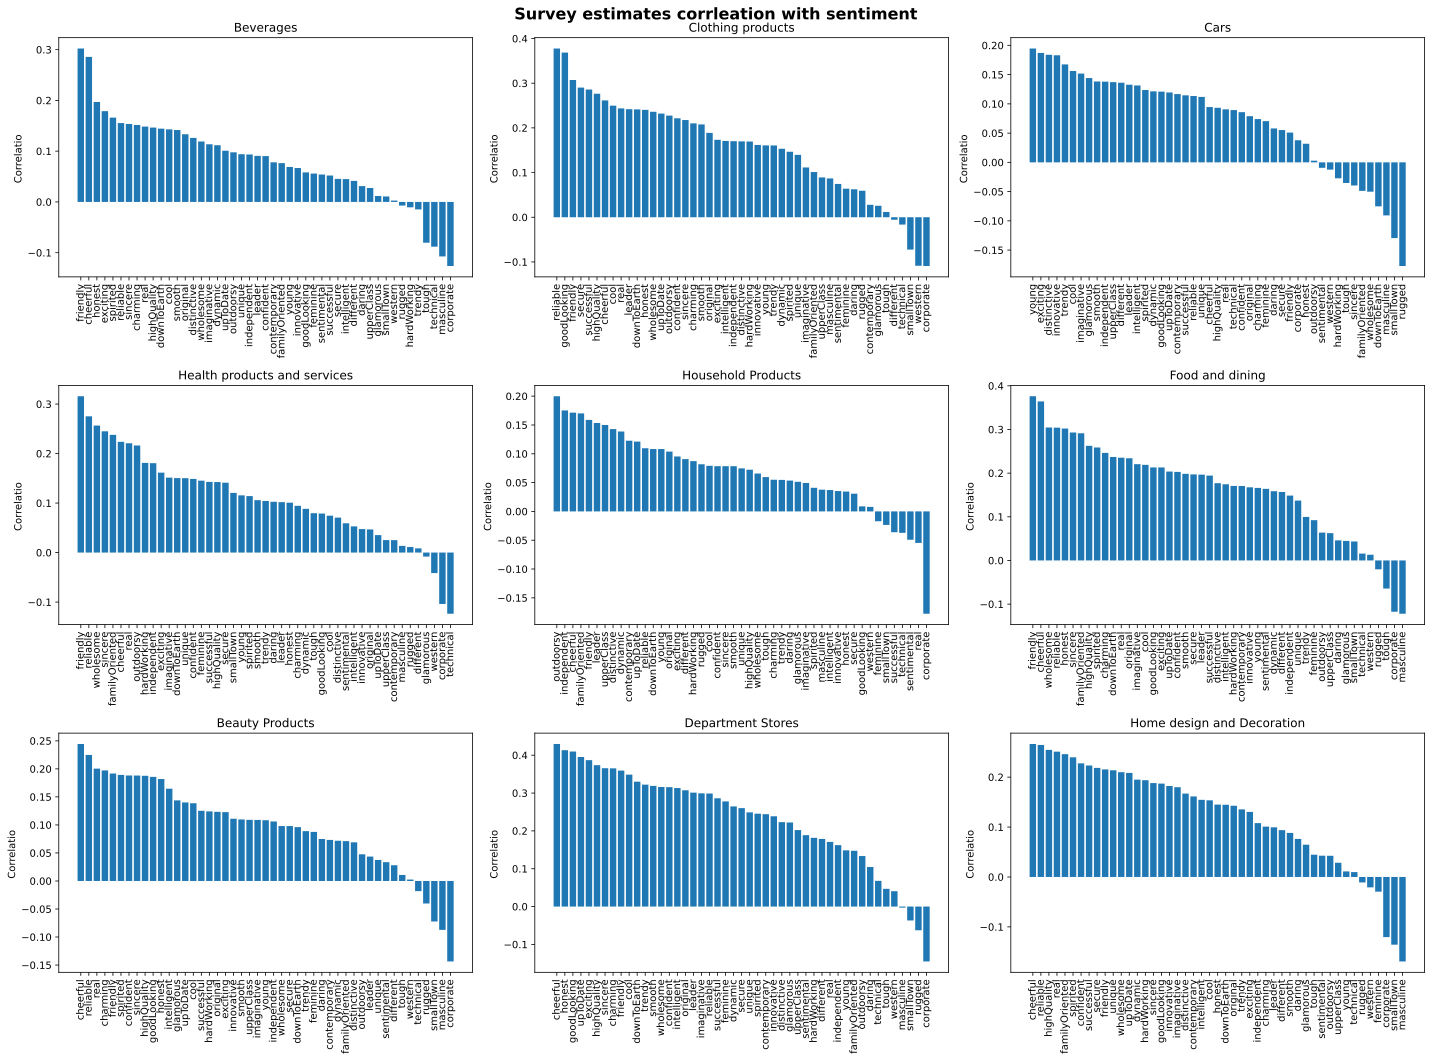

In [ ]:
cut_no = lambda x: x.str.replace('_no', '')

numerical_columns = ['charming_no',
       'cheerful_no', 'confident_no', 'contemporary_no', 'cool_no',
       'corporate_no', 'daring_no', 'different_no', 'distinctive_no',
       'downToEarth_no', 'dynamic_no', 'exciting_no', 'familyOriented_no',
       'feminine_no', 'friendly_no', 'glamorous_no', 'goodLooking_no',
       'hardWorking_no', 'highQuality_no', 'honest_no', 'imaginative_no',
       'independent_no', 'innovative_no', 'intelligent_no', 'leader_no',
       'masculine_no', 'original_no', 'outdoorsy_no', 'real_no', 'reliable_no',
       'rugged_no', 'secure_no', 'sentimental_no', 'sincere_no',
       'smallTown_no', 'smooth_no', 'spirited_no', 'successful_no',
       'technical_no', 'tough_no', 'trendy_no', 'unique_no', 'upToDate_no',
       'upperClass_no', 'western_no', 'wholesome_no', 'young_no', 'sentiment']

brands_numerical = brands[numerical_columns]

fig, axes = plt.subplots(3, 3, figsize = (20, 15))

for i, category in enumerate(categories['Category'].unique()):
  row = i // 3
  col = i % 3

  brands_in_category = categories.loc[(categories['Category'] == category), 'Brand'].values

  correlation_matrix = brands[brands['brandName'].isin(brands_in_category)][numerical_columns].corr()
  sorted_correlation_with_sentiment = correlation_matrix['sentiment'].sort_values(ascending = False)[1:]

  axes[row, col].bar(cut_no(sorted_correlation_with_sentiment.index), sorted_correlation_with_sentiment.values)
  axes[row, col].set_title(f'{category}')
  axes[row, col].set_ylabel('Correlation')
  axes[row, col].tick_params(axis = 'x', rotation = 90)

plt.suptitle('Survey estimates corrleation with sentiment', weight = 'bold', fontsize = 16)
plt.tight_layout()
plt.show()


### Linear Regression

Now let's run 9 linear regressions of `sentiment` on all the other numerical columns from the survey for each category separately. The main purpose of running all these linear regressions is to learn to predict the sentiment based on numerical answers from the survey. The obtained weights will give the companies from each category the understanding of which attributes they should boost in their advertising campaign.

In [ ]:
results = {}

for category in categories['Category'].unique():

  brands_in_category = categories.loc[(categories['Category'] == category), 'Brand'].values
  category_subsample = brands[brands['brandName'].isin(brands_in_category)][numerical_columns]

  X, y = category_subsample.drop(columns = 'sentiment'), category_subsample['sentiment']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  model = LinearRegression()
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  results[category] = mean_absolute_error(y_test, y_pred)

  baseline = np.mean(np.abs(y_test - np.median(y_test)))

  print(f'MAE for category {category} is {np.round(mean_squared_error(y_test, y_pred), 3)}, baseline is {np.round(baseline, 4)}')


MAE for category Beverages is 0.123, baseline is 0.2338
MAE for category Clothing products is 0.215, baseline is 0.2776
MAE for category Cars is 0.127, baseline is 0.2952
MAE for category Health products and services is 0.417, baseline is 0.4191
MAE for category Household Products is 0.171, baseline is 0.2478
MAE for category Food and dining is 0.199, baseline is 0.3122
MAE for category Beauty Products is 0.113, baseline is 0.2261
MAE for category Department Stores is 0.275, baseline is 0.4306
MAE for category Home design and Decoration is 0.162, baseline is 0.288


## Example of feature importances

Now let's see the most negatively and positively impacting features for some categories, for example, `food and dining`, `beverages`, `cars`.

<ipython-input-118-a2a7ed41d316>:6: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



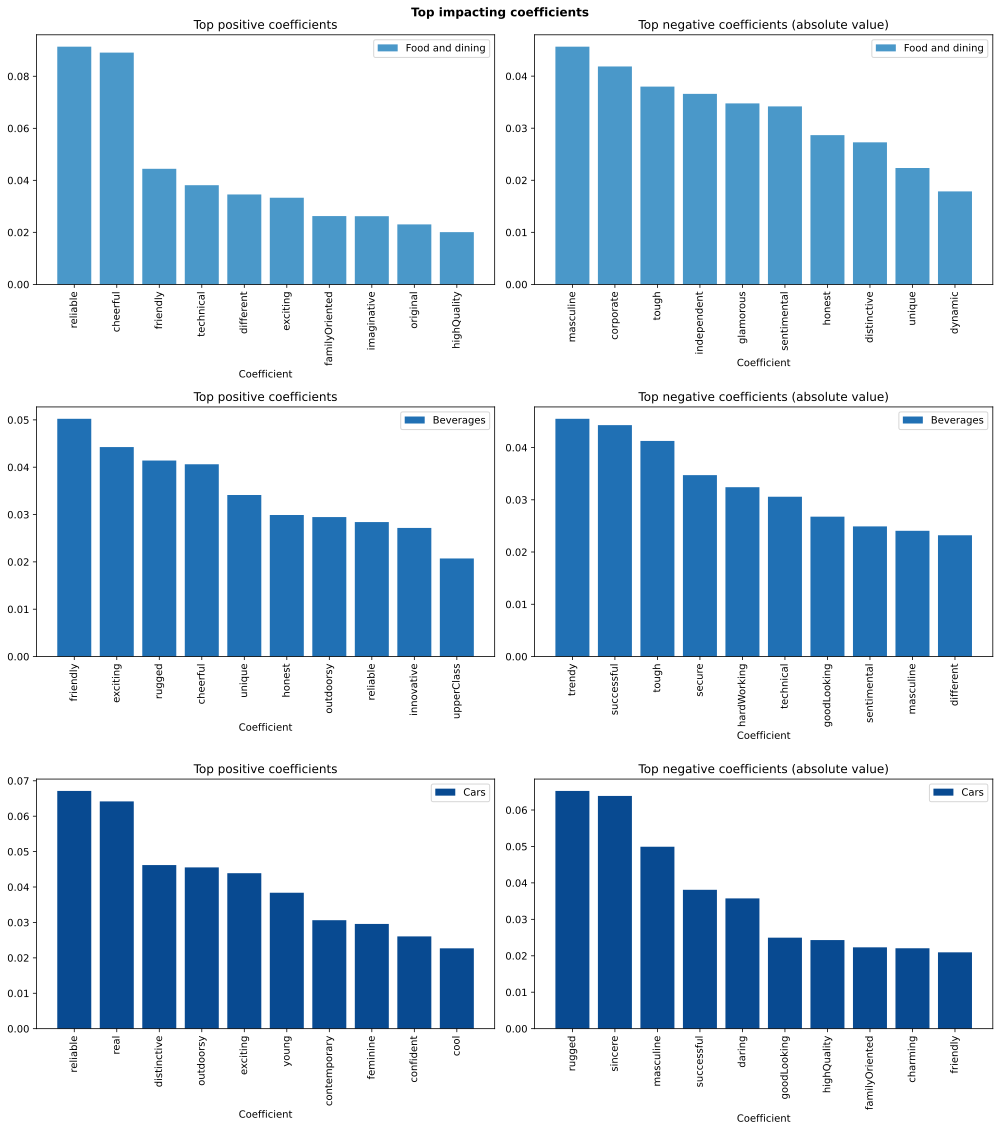

In [ ]:
#food and dining, beverages, cars
sample_subset = ['Food and dining', 'Beverages', 'Cars']

fig, axes = plt.subplots(3, 2, figsize = (14, 16))

cmap = cm.get_cmap('Blues')
colors = [cmap(0.6), cmap(0.75), cmap(0.9)]

for i, category in enumerate(sample_subset):
  row = i % 3
  color = colors[row]

  brands_in_category = categories.loc[(categories['Category'] == category), 'Brand'].values
  category_subsample = brands[brands['brandName'].isin(brands_in_category)][numerical_columns]

  X, y = category_subsample.drop(columns = 'sentiment'), category_subsample['sentiment']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

  model = LinearRegression().fit(X_train, y_train)

  features, coefficients = cut_no(category_subsample.drop(columns = 'sentiment').columns), model.coef_

  coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
    })

  # находим самые положительные и самые отрицательные признаки
  top_positive = coef_df.sort_values(by = 'Coefficient', ascending = False).head(10)
  top_negative = coef_df.sort_values(by = 'Coefficient').head(10)

  axes[i, 0].bar(top_positive['Feature'], top_positive['Coefficient'], label = category, color = color)
  axes[i, 0].set_title('Top positive coefficients')
  axes[i, 0].set_xlabel('Coefficient')
  axes[i, 0].tick_params(axis = 'x', rotation = 90)
  axes[i, 0].legend()

  axes[i, 1].bar(top_negative['Feature'], np.abs(top_negative['Coefficient']), label = category, color = color)
  axes[i, 1].set_title('Top negative coefficients (absolute value)')
  axes[i, 1].set_xlabel('Coefficient')
  axes[i, 1].tick_params(axis = 'x', rotation = 90)
  axes[i, 1].legend()

plt.suptitle('Top impacting coefficients', weight = 'bold')
plt.tight_layout()
plt.show()

# Centriods and peripheral analysis

## TF-IDF calculation

Term Frequency (TF) is the number of times a word appears in a text, relative to the total number of words in that text:

$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ where $n_{td}$ is the number of occurrences of the word $t$ in the text $d$.

IDF (Inverse Document Frequency):

$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ number of texts in the collection containing word $t$.

Then for each pair (word, text) $(t, d)$ we calculate:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

It is the value of the new feature.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features = 2000, max_df = 0.8)
tfidf_matrix = tfidf_vectorizer.fit_transform(brandwise['Words'])

feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = feature_names)
tfidf_df.insert(0, 'Brand', brandwise['Brand'])

grouped_df = categories.merge(tfidf_df, on = 'Brand', how='left')


tsne_dict = {}

for category in categories['Category'].unique():
  local_df = grouped_df[grouped_df['Category'] == category]
  brand_names = list(local_df['Brand'].values)
  all_columns = list(local_df.columns)
  columns_to_remove = ['Brand', 'Category']
  final_columns = list(set(all_columns) - set(columns_to_remove))

  matrix = local_df[final_columns].values

  cosine_distances = squareform(pdist(matrix, 'cosine'))

  average_distances = np.mean(cosine_distances, axis=1)

  centroid_index = np.argmin(average_distances)

  tsne_results = TSNE(n_components = 2, perplexity = 9).fit_transform(matrix)

  tsne_dict[f'tsne_{category}_0'] = tsne_results[:, 0]
  tsne_dict[f'tsne_{category}_1'] = tsne_results[:, 1]



## Visualization

Now let's visualize the mutual disposition of our brands:

In [ ]:
def plot_tsne_category(category, tsne_dict, brand_names):

    tsne_x = tsne_dict[f'tsne_{category}_0']
    tsne_y = tsne_dict[f'tsne_{category}_1']
    df = pd.DataFrame({f'tsne_{category}_0': tsne_x, f'tsne_{category}_1': tsne_y, 'Brand': brand_names})

    centroid = df[[f'tsne_{category}_0', f'tsne_{category}_1']].mean().values
    df['distance_to_centroid'] = np.sqrt((df[f'tsne_{category}_0'] - centroid[0]) ** 2 + (df[f'tsne_{category}_1'] - centroid[1]) ** 2)
    farthest_points = df.nlargest(3, 'distance_to_centroid')

    fig = px.scatter(df,
                     x = f'tsne_{category}_0',
                     y = f'tsne_{category}_1')

    fig.add_scatter(x = [centroid[0]],
                    y = [centroid[1]],
                    mode = 'markers',
                    marker = dict(color = 'red', size = 10),
                    name = 'Centroid')

    # аннотации
    for _, row in df.iterrows():
        fig.add_annotation(x = row[f'tsne_{category}_0'],
                           y = row[f'tsne_{category}_1'],
                           text = row['Brand'],
                           showarrow = False,
                           yshift = 10)

    # выдалеям самые дальние
    for _, row in farthest_points.iterrows():
        fig.add_scatter(x = [row[f'tsne_{category}_0']],
                        y = [row[f'tsne_{category}_1']],
                        mode = 'markers',
                        marker = dict(color = 'green', size = 10),
                        name = f'Farthest - {row["Brand"]}')

    fig.show()



for category in categories['Category'].unique():
    local_df = grouped_df[grouped_df['Category'] == category]
    brand_names = list(local_df['Brand'].values)
    plot_tsne_category(category, tsne_dict, brand_names)

As plotly charts do not remain in the notebook, we downloaded them and will now display them manually:

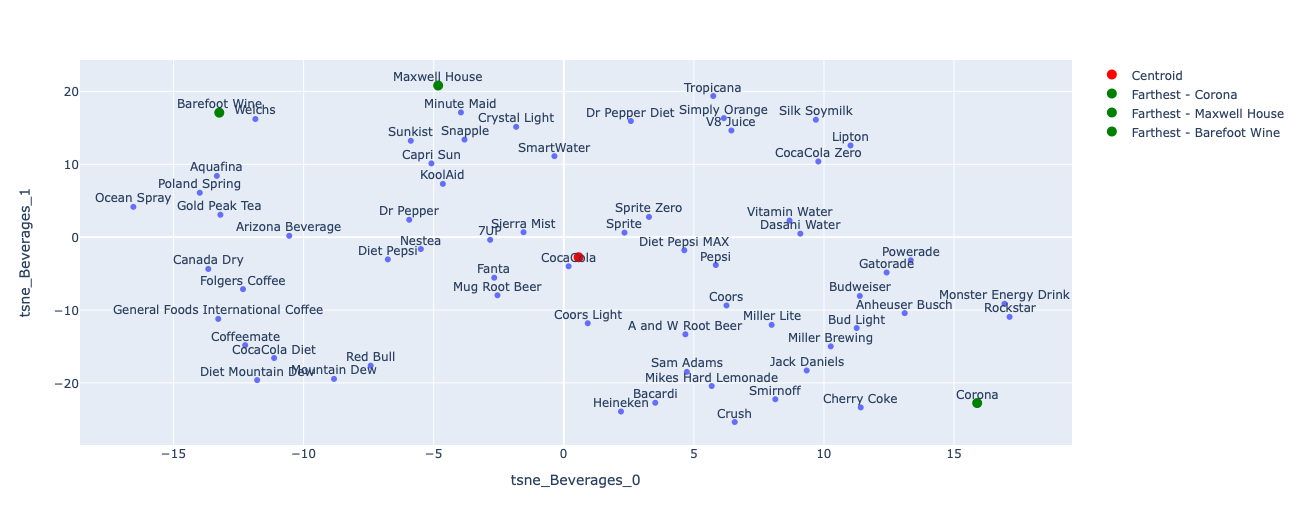

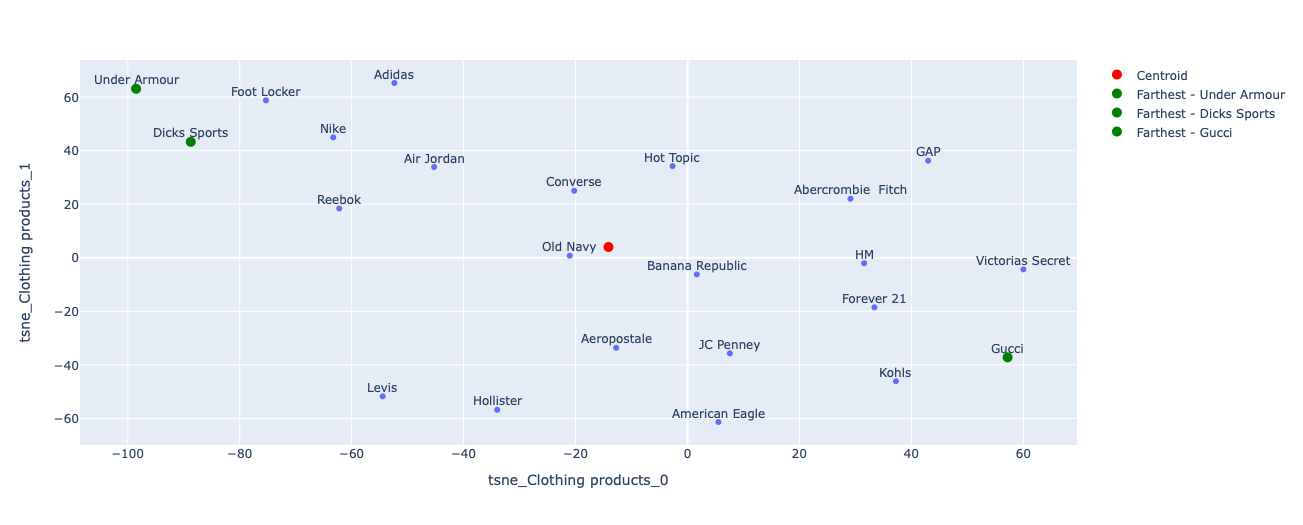

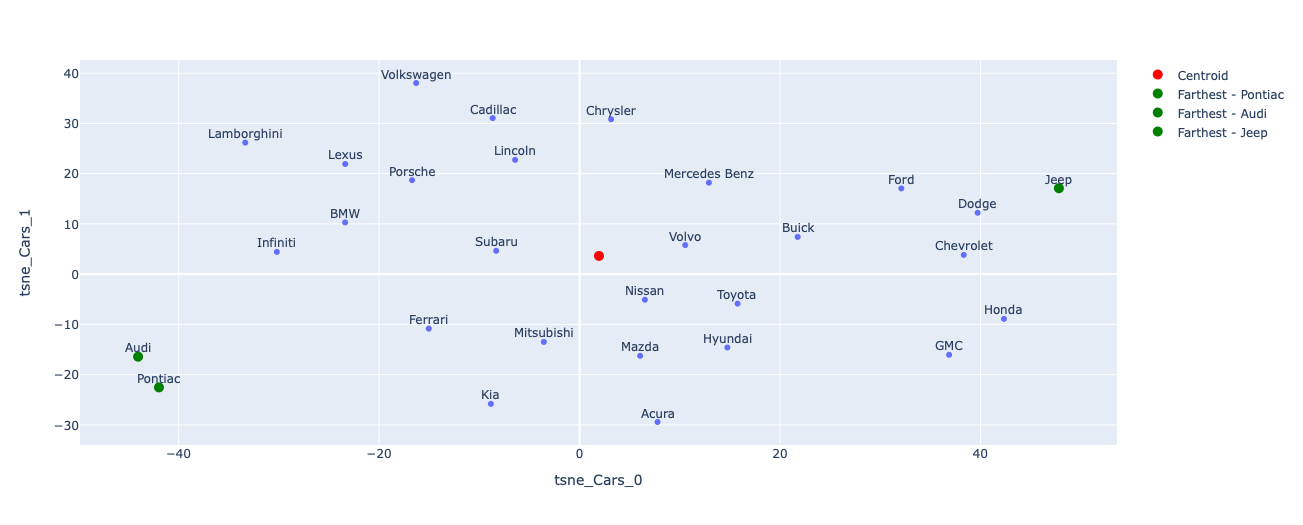

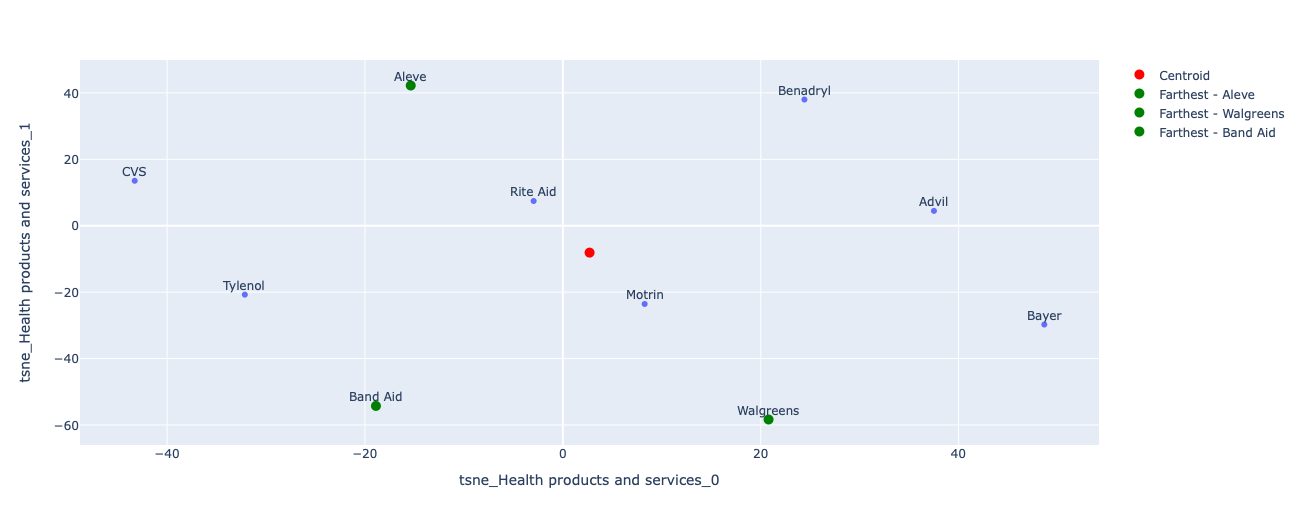

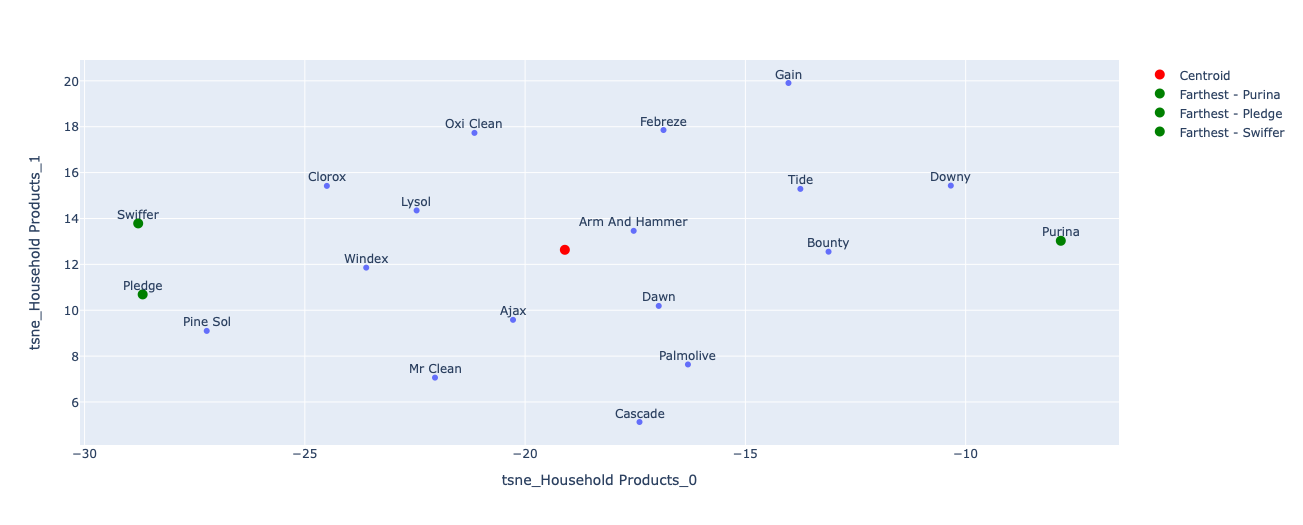

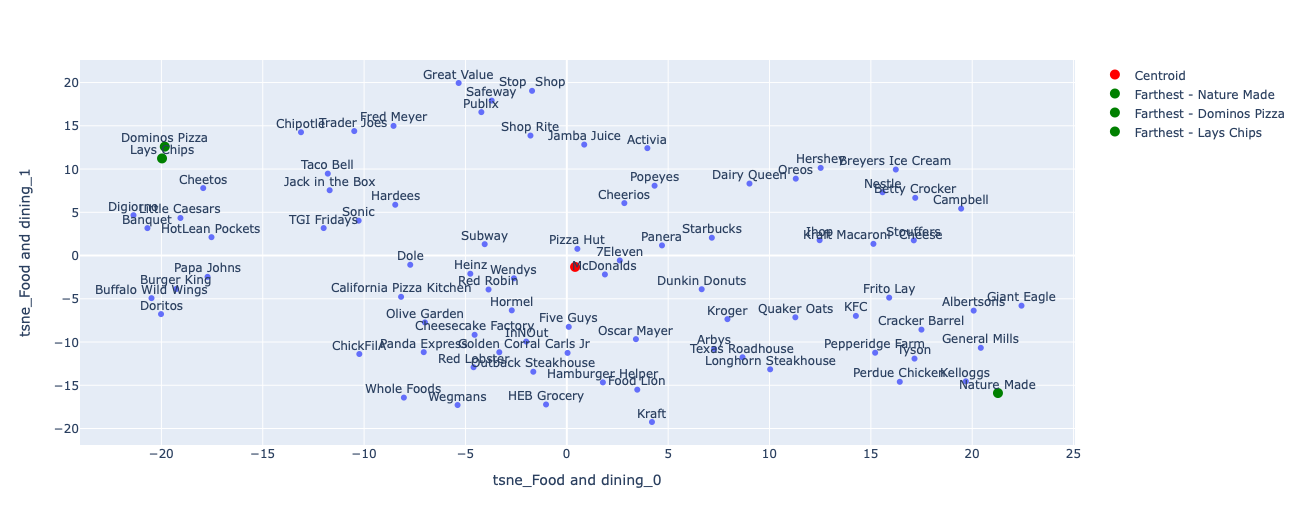

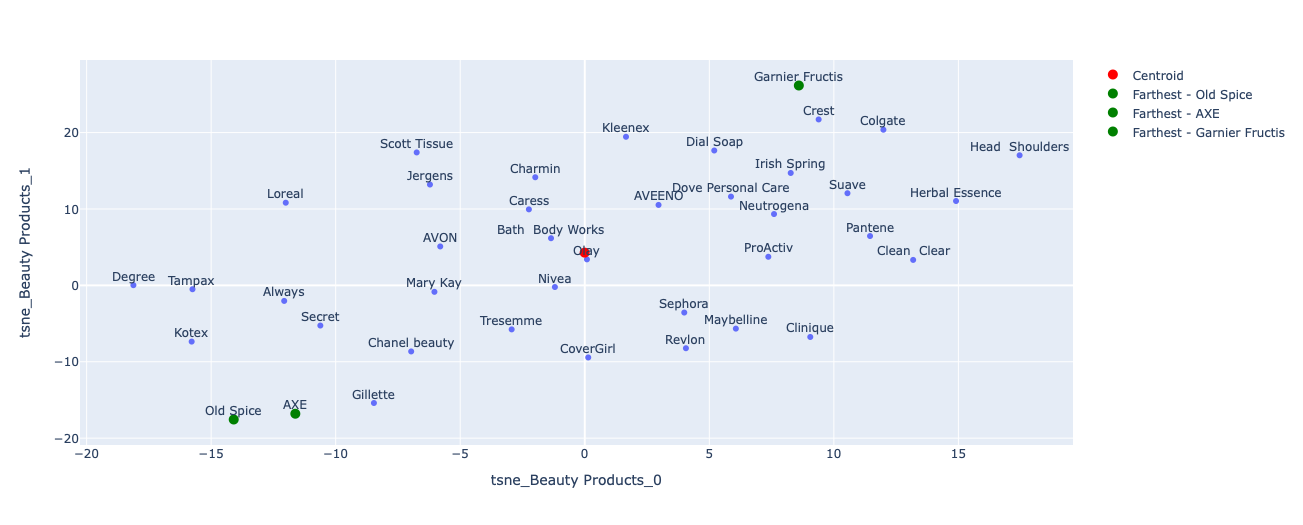

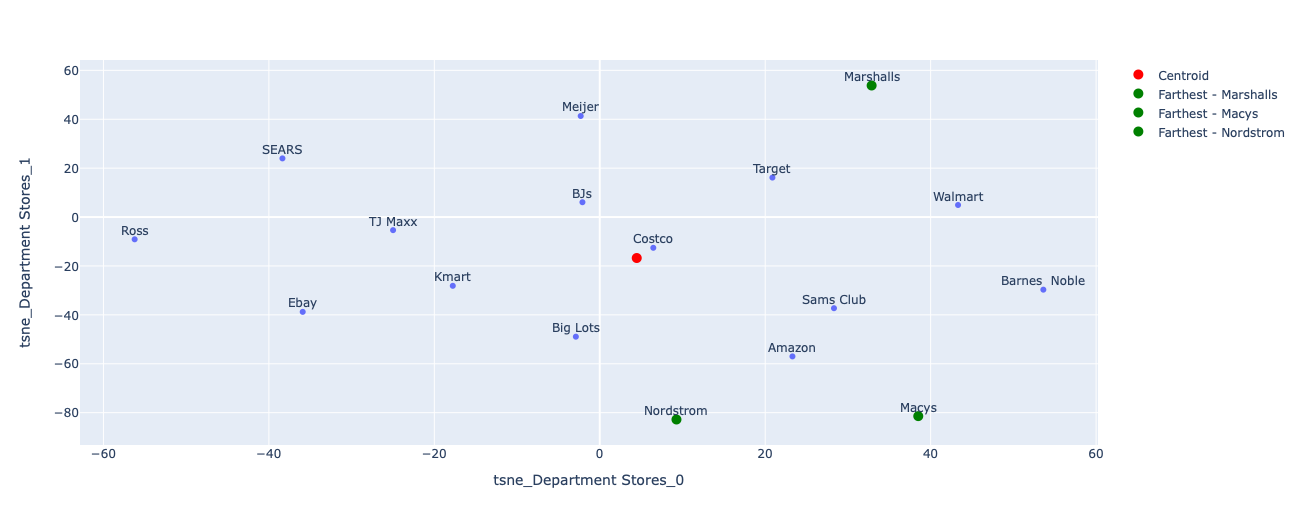

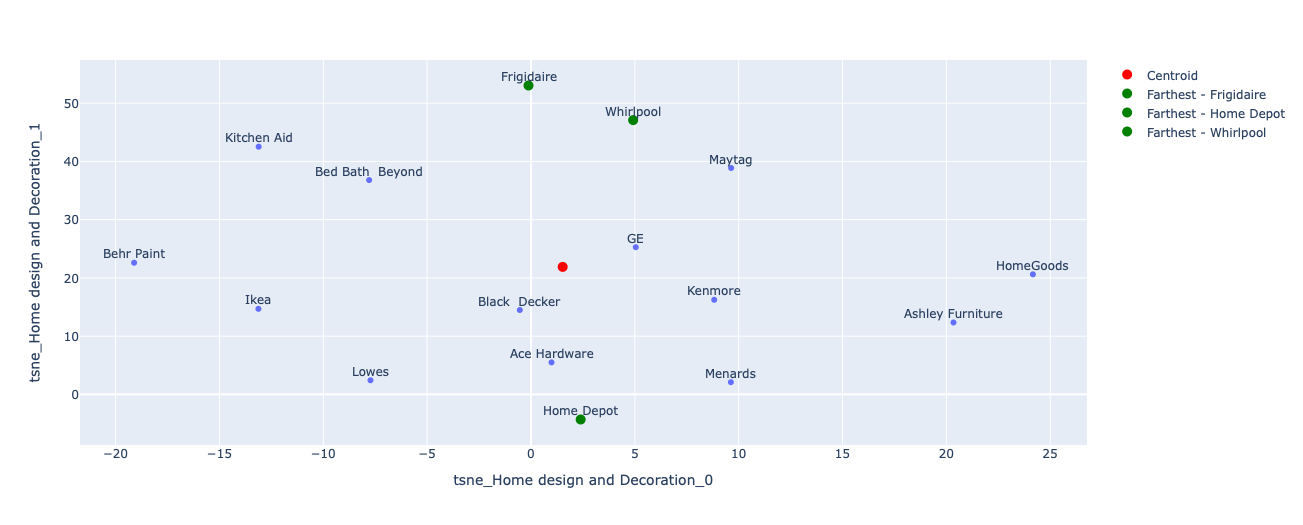

In [ ]:
from IPython.display import Image, display

for i in range(2, 11):
  display(Image(f'newplot-{i}.png'))

## Key textual attributes for brands

Let us now find the key textual attributes for our brands:

In [ ]:
def find_key_features(grouped_df, tsne_dict, brand_names, category):
    local_df = grouped_df[grouped_df['Category'] == category]
    brand_names = list(local_df['Brand'].values)
    tsne_x = tsne_dict[f'tsne_{category}_0']
    tsne_y = tsne_dict[f'tsne_{category}_1']
    df = pd.DataFrame({f'tsne_{category}_0': tsne_x, f'tsne_{category}_1': tsne_y, 'Brand': brand_names})

    local_df = local_df.merge(df, on ='Brand', how='left')


    tsne_x = f'tsne_{category}_0'
    tsne_y = f'tsne_{category}_1'

    centroid = local_df[[tsne_x, tsne_y]].mean().values

    local_df['distance_to_centroid'] = np.sqrt((local_df[tsne_x] - centroid[0]) ** 2 + (local_df[tsne_y] - centroid[1]) ** 2)
    closest_brand = local_df.loc[local_df['distance_to_centroid'].idxmin()]['Brand']

    farthest_brands = local_df.nlargest(3, 'distance_to_centroid')['Brand'].values

    print(category)
    for brand in farthest_brands:
        brand_vector = local_df[local_df['Brand'] == brand][final_columns].values.flatten()
        centroid_vector = local_df[local_df['Brand'] == closest_brand][final_columns].values.flatten()
        differences = np.abs(brand_vector - centroid_vector)
        top_features = np.argsort(differences)[-3:]

        exotic = [final_columns[i] for i in top_features]
        print(f"For brand {brand}, the most distinctive characteristics are: {exotic}")

    print()

for category in categories['Category'].unique():
    local_df = grouped_df[grouped_df['Category'] == category]
    brand_names = list(local_df['Brand'].values)
    find_key_features(grouped_df, tsne_dict, brand_names, category)

Beverages
For brand Corona, the most distinctive characteristics are: ['tennis', 'bronzing', 'bikini']
For brand Maxwell House, the most distinctive characteristics are: ['clock', 'bubble', 'tennis']
For brand Barefoot Wine, the most distinctive characteristics are: ['bunch', 'vine', 'grape']

Clothing products
For brand Under Armour, the most distinctive characteristics are: ['instrument', 'offspring', 'baseball']
For brand Dicks Sports, the most distinctive characteristics are: ['ball', 'tennis', 'basketball']
For brand Gucci, the most distinctive characteristics are: ['bag', 'jewelry', 'accessory']

Cars
For brand Pontiac, the most distinctive characteristics are: ['thunderbolt', 'lightning', 'thunder']
For brand Audi, the most distinctive characteristics are: ['thunderstorm', 'thunder', 'lightning']
For brand Jeep, the most distinctive characteristics are: ['hike', 'adventure', 'valley']

Health products and services
For brand Aleve, the most distinctive characteristics are: ['teac